## Sea Ice Analysis

This notebook includes sea ice analysis related to the following paper:

Joseph Hamman, Bart Nijssen, Andrew Roberts, and John Cassano. On the relationship
between arctic winter precipitation and minimum sea ice extent. Geophysical Research
Letters, Manuscript in Preparation

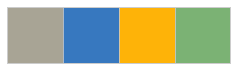

In [32]:
%matplotlib inline

# Builtin imports
from collections import OrderedDict
from datetime import datetime

# Processing Imports
import numpy as np
import pandas as pd
import xarray as xr

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

# Constants
km_to_m = 1000.

# Set style for figures
sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams.update({'mathtext.default':  'regular' })
colors = OrderedDict(zip(['NSIDC', '$RASM_{RSH}$', '$RASM_{RSI}$', '$RASM_{CONTROL}$'],
                         sns.xkcd_palette(["greyish", "windows blue", "amber", "faded green"])))
zorder = {'$RASM_{CONTROL}$': 10, '$RASM_{RSI}$': 10, '$RASM_{RSH}$': 10, 'NSIDC': 9}
sns.palplot(colors.values())

### Functions for processing sea ice data

In [3]:
def read_obs_seaice_extent():
    '''
    Return sea ice extent in 10^6 sq km as a pandas.Series
    
    see also: http://nsidc.org/data/docs/noaa/g02135_seaice_index/#jul-2016
    '''
    df = pd.read_csv('ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/NH_seaice_extent_final_v2.csv',
                     skiprows=[1])
    df.columns = [c.strip() for c in df.columns]
    df.index = [datetime(int(row['Year']), int(row['Month']), int(row['Day'])) for _, row in df.iterrows()]
    return df['Extent']

def get_rasm_sea_ice_ts(ds, mask=None, extent_thresh=0.15, minthick=0.1, maxlat=84):
    '''
    Return a pandas.DataFrame from a RASM CICE dataset
    
    see also: https://svn.nps.edu/repos/racm/rasm/trunk/scripts/rasm_utils/Post_processing/matlab/NPS_scripts/RASM_sea_ice/functions/RASM_sea_ice_extent_volume_cesm.m
    '''
    df = pd.DataFrame()
    
    if mask:
        ds = ds.where(mask)
    
    # Extent
    df['extent'] = (ds['aice'].where(
        (ds['aice'] > extent_thresh) & (ds['hi'] > minthick)) * ds['uarea']).sum(
            dim=('ni', 'nj')).to_series() / km_to_m ** 2
    
    # Area
    df['area'] = (ds['aice'].where((ds['hi'] > minthick) & (ds['ULAT'] < maxlat)) * ds['uarea']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 2
    
    # Volume
    df['volume'] = (ds['aice'] * ds['uarea'] * ds['hi']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 3
    
    # Snow Volume
    df['snow_volume'] = (ds['aice'] * ds['uarea'] * ds['hs']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 3
    
    return df

### Read the RASM data and observations

In [4]:
rasm_sea_ice_ds = OrderedDict()
rasm_sea_ice_dfs = OrderedDict()

rasm_sea_ice_ds['$RASM_{CONTROL}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ice/monthly_mean_timeseries/R1010RBRbaaa01a.cice.hmm.197909-201412.nc', decode_times=False)
rasm_sea_ice_ds['$RASM_{RSI}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/ice/monthly_mean_timeseries/R1010RBRbrsi01a.cice.hmm.197909-201412.nc', decode_times=False)
rasm_sea_ice_ds['$RASM_{RSH}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/ice/monthly_mean_timeseries/R1010RBRbrsh01a.cice.hmm.197909-201412.nc', decode_times=False)

# Update the timestamps in the RASM sea ice datasets
for k, ds in rasm_sea_ice_ds.items():
    rasm_sea_ice_ds[k].time.values = pd.date_range('1979-09', freq='MS', periods=len(rasm_sea_ice_ds[k].time.values))
    rasm_sea_ice_dfs[k] = get_rasm_sea_ice_ts(rasm_sea_ice_ds[k])
    
obs_extent = read_obs_seaice_extent()

In [5]:
ds_all = xr.concat(rasm_sea_ice_ds.values(), dim=xr.DataArray(list(rasm_sea_ice_ds.keys()), dims=('dataset', ), name='dataset'))


In [6]:
# Monthly means of observations
# First resample to daily frequency, using linear interpolation
# Then resample to monthly mean frequency
# Finally, export to a pandas.DataFrame and convert units
dfo = obs_extent.resample('1D').first().interpolate().resample('MS').mean().to_frame(name='extent') * km_to_m**2
dfo.head()

,extent
1978-10-01,1.043925e+07
1978-11-01,1.167938e+07
1978-12-01,1.366745e+07
1979-01-01,1.540777e+07
1979-02-01,1.618918e+07


In [7]:
# Save the timeseries of RASM sea ice summaries for use elsewhere
ds = xr.concat([xr.Dataset(df) for df in rasm_sea_ice_dfs.values()],
               dim=xr.DataArray(list(rasm_sea_ice_ds.keys()),
                                dims=('dataset', ),
                                name='dataset'))
ds.to_netcdf('../data/sea_ice_timeseries.nc')
ds

<xarray.Dataset>
Dimensions:      (dataset: 3, time: 424)
Coordinates:
  * time         (time) datetime64[ns] 1979-09-01 1979-10-01 1979-11-01 ...
  * dataset      (dataset) <U16 '$RASM_{CONTROL}$' '$RASM_{RSI}$' '$RASM_{RSH}$'
Data variables:
    extent       (dataset, time) float64 6.906e+06 8.711e+06 1.084e+07 ...
    area         (dataset, time) float64 5.585e+06 7.318e+06 9.443e+06 ...
    snow_volume  (dataset, time) float64 1.927e+03 2.406e+03 2.904e+03 ...
    volume       (dataset, time) float64 2.699e+04 2.918e+04 3.142e+04 ...

In [8]:
rasm_sea_ice_dfs['NSIDC'] = dfo

### Plot timeseries of minimum annual sea ice extent (from monthly means)

$RASM_{CONTROL}$ 5.0786674032
$RASM_{RSI}$ 4.24667287802
$RASM_{RSH}$ 2.61223678396
NSIDC 3.5656


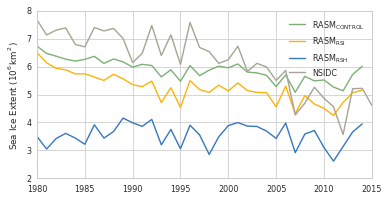

In [36]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 3))

ex = {}

for k, df in rasm_sea_ice_dfs.items():
    (df['extent']['1980':].resample('AS').min() / km_to_m**2).plot(ax=ax, label=k, color=colors[k])
    ex[k] = (df['extent']['1990':].resample('AS').min() / km_to_m**2).min()
    print(k, ex[k])
plt.legend()

plt.ylabel('Sea Ice Extent ($10^6 km^2$)')
plt.xlabel('')

fig.savefig('../figs/sea_ice_min_timeseries.png', dpi=300)

In [10]:
# Print percent change from control simulation (1990-2014)
for key, value in ex.items():
    print(key, (ex['$RASM_{CONTROL}$'] - value) / ex['$RASM_{CONTROL}$'])
    

$RASM_{CONTROL}$ 0.0
$RASM_{RSH}$ 0.485645233961
$RASM_{RSI}$ 0.163821423835
NSIDC 0.297926066638


### Plot all sea ice variables - timeseries and annual cycle

skipping area for NSIDC
skipping volume for NSIDC
skipping snow_volume for NSIDC


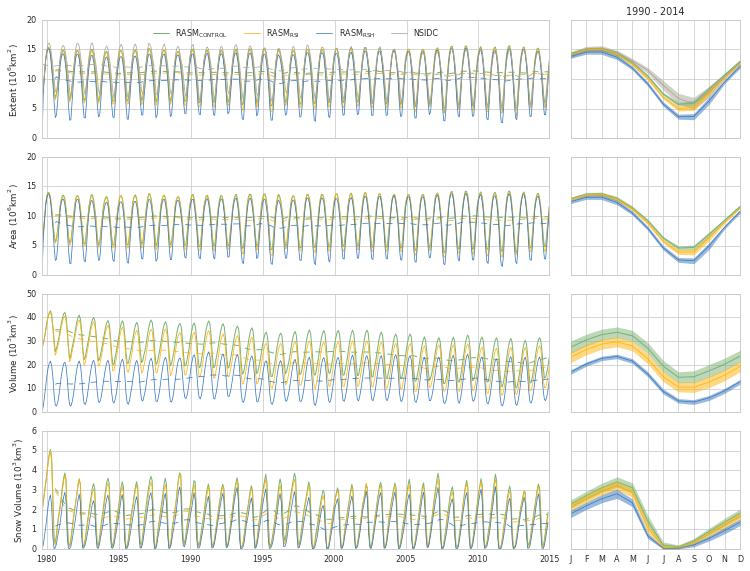

In [11]:
rows = ['extent', 'area', 'volume', 'snow_volume']
ylabels = {'extent': 'Extent ($10^6 km^2$)', 'area': 'Area ($10^6 km^2$)',
           'volume': 'Volume ($10^3 km^3$)', 'snow_volume': 'Snow Volume ($10^3 km^3$)'}
ylims = {'extent': (0, 20), 'area': (0, 20),
         'volume': (0, 50), 'snow_volume': (0, 6)}
lws = dict(zip(['NSIDC', '$RASM_{RSH}$', '$RASM_{RSI}$', '$RASM_{CONTROL}$'],
               [0.75, 0.75, 0.75, 1]))
scale = {'extent': 10**6, 'area': 10**6,
         'volume': 10**3, 'snow_volume': 10**3}

from matplotlib import gridspec
from matplotlib.dates import YearLocator

sns.set_style('whitegrid')
sns.set_context('paper')

fig = plt.figure(figsize=(10.5, 8)) 
gs = gridspec.GridSpec(len(rows), 2, width_ratios=[3, 1]) 

bot_ax1 = plt.subplot(gs[-1, 0])
bot_ax2 = plt.subplot(gs[-1, 1])
    
annual_slice = slice('1990', '2014')


year_x_ticks = pd.date_range('1980', '2015', freq='5AS')
    
for i, var in enumerate(rows):
    ax1 = plt.subplot(gs[i, 0], sharex=bot_ax1)
    ax2 = plt.subplot(gs[i, 1], sharey=ax1, sharex=bot_ax2)
    
    for label, df in rasm_sea_ice_dfs.items():
        try:
            # Timeseries
            s = df[var] / scale[var]
            s.plot(ax=ax1, c=colors[label], label=label, lw=lws[label])
            s.rolling(12, min_periods=12, center=False).mean().plot(
                ax=ax1, c=colors[label], lw=lws[label], ls='--', label='')
            ax1.set_ylabel(ylabels[var])
            ax1.set_ylim(ylims[var])
            ax1.set_xticks(year_x_ticks)
            ax1.set_xticklabels(year_x_ticks.year)

            # Seasonal cycle
            s_group = s[annual_slice].groupby(lambda x: x.month) 
            m = s_group.mean()
            std = s_group.std() * 2 # (two standard deviations)
            m.plot(ax=ax2, color=colors[label], label=label, lw=lws[label])
            ax2.fill_between(m.index, m + std/2, m - std/2, alpha=0.5, color=colors[label], zorder=zorder[label])
            ax2.set_xticks(range(1, 13))
            ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        except Exception as e:
            print('skipping', var, 'for', label)
        
        ax1.set_xlabel('')
    
    if i == 0:
        ax1.legend(loc='upper center', ncol=4, frameon=False)
        ax2.set_title('%s - %s' % (annual_slice.start, annual_slice.stop))
        

fig.tight_layout()

fig.savefig('../figs/sea_ice_timeseries.png', dpi=300)

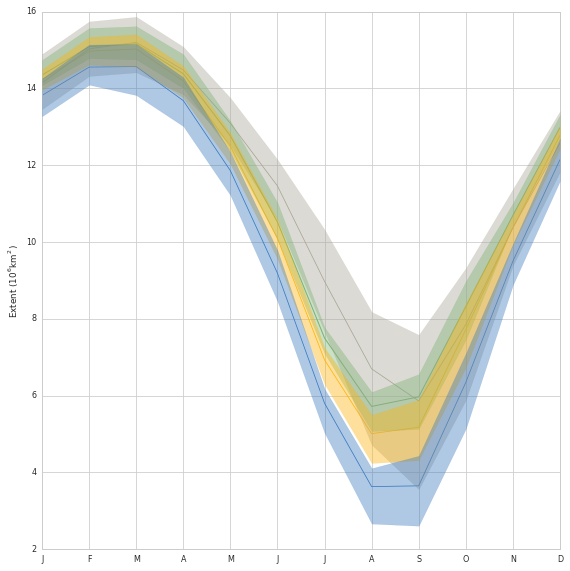

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    
var = 'extent'

save_stdevs = {}

for label, df in rasm_sea_ice_dfs.items():
    try:
        # Timeseries
        s = df[var] / scale[var]

        # Seasonal cycle
        s_group = s[annual_slice].groupby(lambda x: x.month) 
        m = s_group.mean()
        std = s_group.std() * 2 # (two standard deviations)
        save_stdevs[label] = std
        m.plot(ax=ax, color=colors[label], label=label, lw=lws[label])
        ax.fill_between(m.index, s_group.max(), s_group.min(), alpha=0.4, color=colors[label], zorder=zorder[label])
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax.set_ylabel(ylabels[var])
#         ax.set_ylim(ylims[var])
#         ax.set_xlim(9,13)
    except Exception as e:
        print(var, e)
#             raise

    ax.set_xlabel('')

if i == 0:
    ax.legend(loc='upper center', ncol=4, frameon=False)
    ax.set_title('%s - %s' % (annual_slice.start, annual_slice.stop))
        
fig.tight_layout()

# fig.savefig('../figs/sea_ice_annual_cycle.png', dpi=300)

In [13]:
# Print the ratio of monthly standard deviations compared to NSIDC
std_df = pd.DataFrame(save_stdevs)
std_df = 1/ std_df.divide(std_df['NSIDC'], axis='rows')
std_df

,$RASM_{CONTROL}$,$RASM_{RSH}$,$RASM_{RSI}$,NSIDC
1,2.487154,1.570966,2.818582,1.0
2,2.184230,1.426300,2.215927,1.0
3,1.594856,1.059436,1.541657,1.0
4,1.403383,0.990881,1.409223,1.0
5,1.553094,1.116816,1.553930,1.0
6,2.021307,1.431407,1.971990,1.0
7,3.346504,2.290341,2.792571,1.0
8,2.856341,2.210314,2.328445,1.0
9,2.505968,1.981777,2.144470,1.0
10,2.514770,1.712232,2.014562,1.0


### Plot the distribution of fall season extents by dataset 

In [14]:
extent_df = pd.DataFrame()

for k, df in rasm_sea_ice_dfs.items():
    extent_df[k] = df['extent']['1985':'2015'] / km_to_m**2

In [15]:
# select fall months only
df = pd.melt(extent_df[(extent_df.index.month > 7) & (extent_df.index.month < 11)] , value_name='extent')
df.head()

,variable,extent
0,$RASM_{CONTROL}$,6.259307
1,$RASM_{CONTROL}$,6.561831
2,$RASM_{CONTROL}$,8.463892
3,$RASM_{CONTROL}$,6.367924
4,$RASM_{CONTROL}$,6.837213


In [16]:
extent_df[extent_df.index.month == 9].mean(axis=0)

$RASM_{CONTROL}$    6.089172
$RASM_{RSI}$        5.313472
$RASM_{RSH}$        3.680129
NSIDC               6.076669
dtype: float64

In [17]:
extent_df[(extent_df.index.month >= 8) & extent_df.index.month <= 10].mean(axis=0)

$RASM_{CONTROL}$    11.129787
$RASM_{RSI}$        10.771988
$RASM_{RSH}$         9.861078
NSIDC               11.449393
dtype: float64

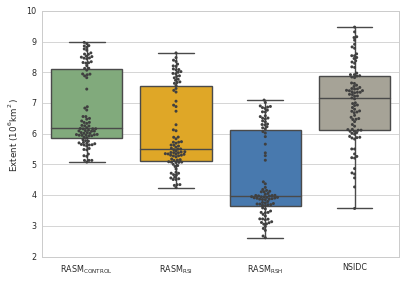

In [18]:
sns.set_context('paper')
ax = sns.boxplot(x="variable", y="extent", data=df, palette=colors)
ax = sns.swarmplot(x="variable", y="extent", data=df, color=".25", size=3, )

plt.ylabel('Extent ($10^6 km^2$)')
plt.xlabel('')

plt.savefig('../figs/seaice_boxplots.png', dpi=300)

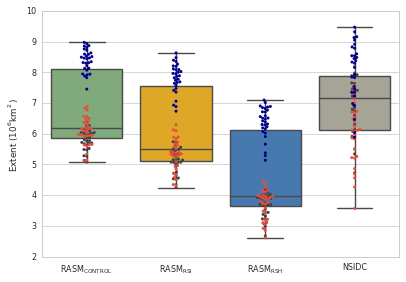

In [19]:
sns.set_style('whitegrid')
sns.set_context('paper')

# plot again, this time coloring the dots
df = pd.melt(extent_df[(extent_df.index.month > 7) & (extent_df.index.month < 11)] , value_name='extent')
ax = sns.boxplot(x="variable", y="extent", data=df, palette=colors)

df = pd.melt(extent_df[extent_df.index.month == 8] , value_name='extent')
ax = sns.swarmplot(x="variable", y="extent", data=df, color="0.25", size=3)

df = pd.melt(extent_df[extent_df.index.month == 9] , value_name='extent')
ax = sns.swarmplot(x="variable", y="extent", data=df, color="#e74c3c", size=3)

df = pd.melt(extent_df[extent_df.index.month == 10] , value_name='extent')
ax = sns.swarmplot(x="variable", y="extent", data=df, color='darkblue', size=3)

plt.ylabel('Extent ($10^6 km^2$)')
plt.xlabel('')
plt.savefig('../figs/seaice_boxplots.png', dpi=300)

In [20]:
extent_df.describe()

,$RASM_{CONTROL}$,$RASM_{RSI}$,$RASM_{RSH}$,NSIDC
count,360.000000,360.000000,360.000000,360.000000
mean,11.129787,10.771988,9.861078,11.449393
std,3.335246,3.562389,3.962715,3.209543
min,5.078667,4.246673,2.612237,3.565600
25%,7.820194,7.237760,6.080074,8.637258
50%,11.683949,11.368105,10.583312,12.127400
75%,14.290024,14.210938,13.707200,14.366069
max,15.620816,15.410562,15.154446,16.054589


In [21]:
from cartopy.feature import LAND
def add_map_features(ax):
    ax.coastlines()
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    ax.add_feature(LAND, facecolor='0.85', )
    ax.gridlines(crs=ccrs.PlateCarree())
    ax.autoscale_view('tight')


In [22]:
da = ds_all['aice'].sel(time=slice('1985', '2014'))
da = da.sel(time=da.indexes['time'].month == 9).mean(dim='time')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


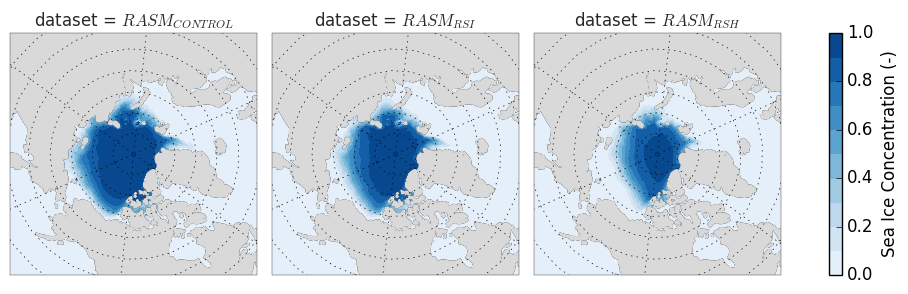

In [23]:
fg = da.plot.pcolormesh('TLON', 'TLAT', col='dataset', transform=ccrs.PlateCarree(),
                        subplot_kws=dict(projection=ccrs.NorthPolarStereo(-114)),
                        cmap='Blues', levels=10)
_ = [add_map_features(ax) for ax in fg.axes.flat]

fg.cbar.set_label('Sea Ice Concentration (-)')

In [24]:
da = ds_all['aice'].sel(time=slice('1985', '2014'))
da = da.sel(time=(da.indexes['time'].month > 7) & (da.indexes['time'].month < 11)).groupby('time.month').mean(dim='time')


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


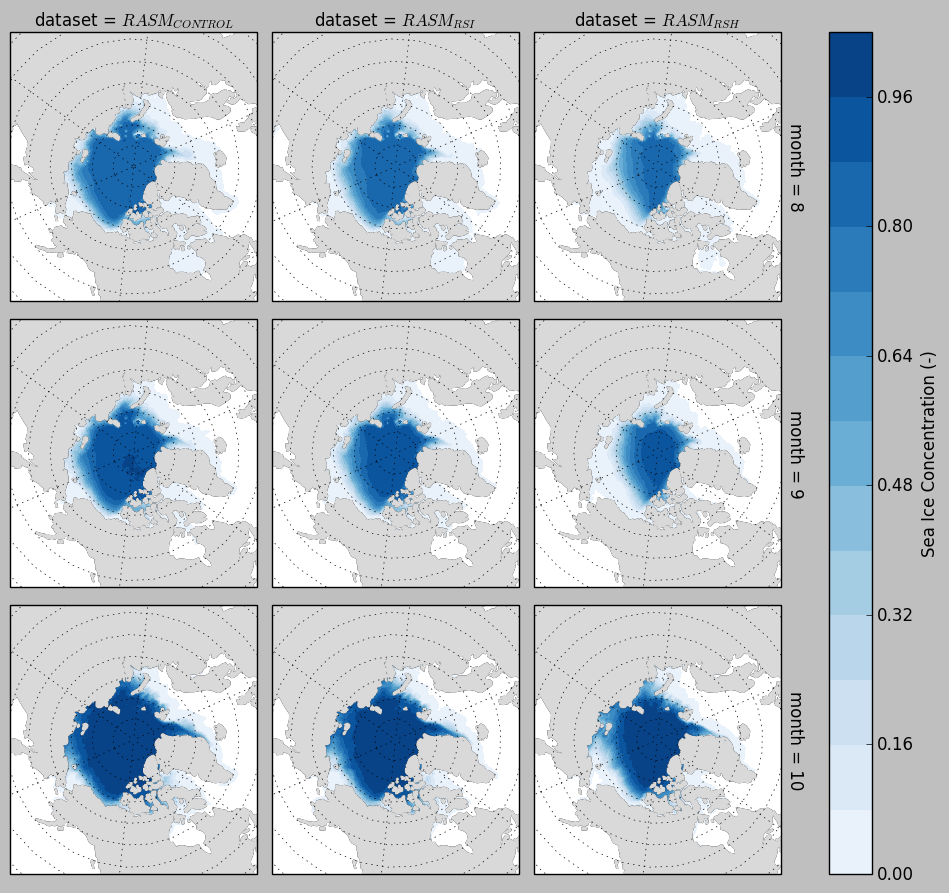

In [25]:
fg = da.where(da > 0).plot.pcolormesh('TLON', 'TLAT', col='dataset', row='month', 
                        transform=ccrs.PlateCarree(),
                        subplot_kws=dict(projection=ccrs.NorthPolarStereo(-114)),
                        cmap='Blues', levels=15,)
_ = [add_map_features(ax) for ax in fg.axes.flat]
fg.cbar.set_label('Sea Ice Concentration (-)')

In [26]:
da = ds_all['aice'].sel(time=slice('1985', '2014'))
da = da.sel(time=(da.indexes['time'].month > 7) & (da.indexes['time'].month < 11)).groupby('time.month').mean(dim='time')

da = (da - da.sel(dataset='$RASM_{CONTROL}$'))[1:]


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


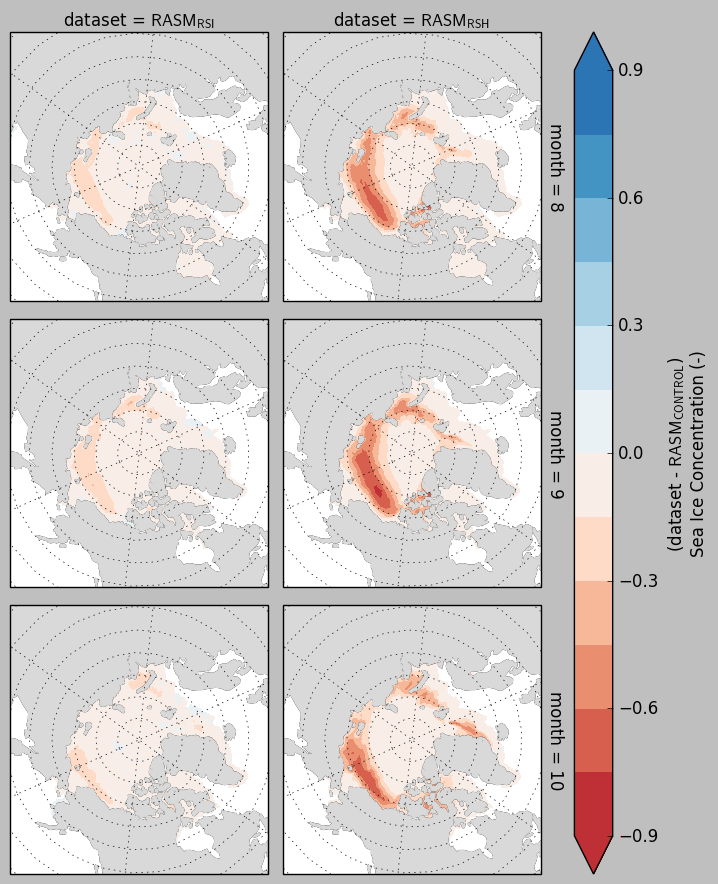

In [27]:
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'sf'

fg = da.where(da != 0).plot.pcolormesh('TLON', 'TLAT', col='dataset', row='month', 
                        transform=ccrs.PlateCarree(),
                        subplot_kws=dict(projection=ccrs.NorthPolarStereo(-114)),
                        cmap='RdBu', levels=15, vmin=-0.8, vmax=0.8, extend='both')
_ = [add_map_features(ax) for ax in fg.axes.flat]
fg.cbar.set_label('(dataset - $RASM_{CONTROL}$)\nSea Ice Concentration (-)')

fg.fig.savefig('../figs/seaice_concentration_changes.png', dpi=300, bbox_inches='tight')

In [28]:
da = ds_all['hi'].sel(time=slice('1985', '2014'))
da = da.sel(time=(da.indexes['time'].month > 7) & (da.indexes['time'].month < 11)).groupby('time.month').mean(dim='time')


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


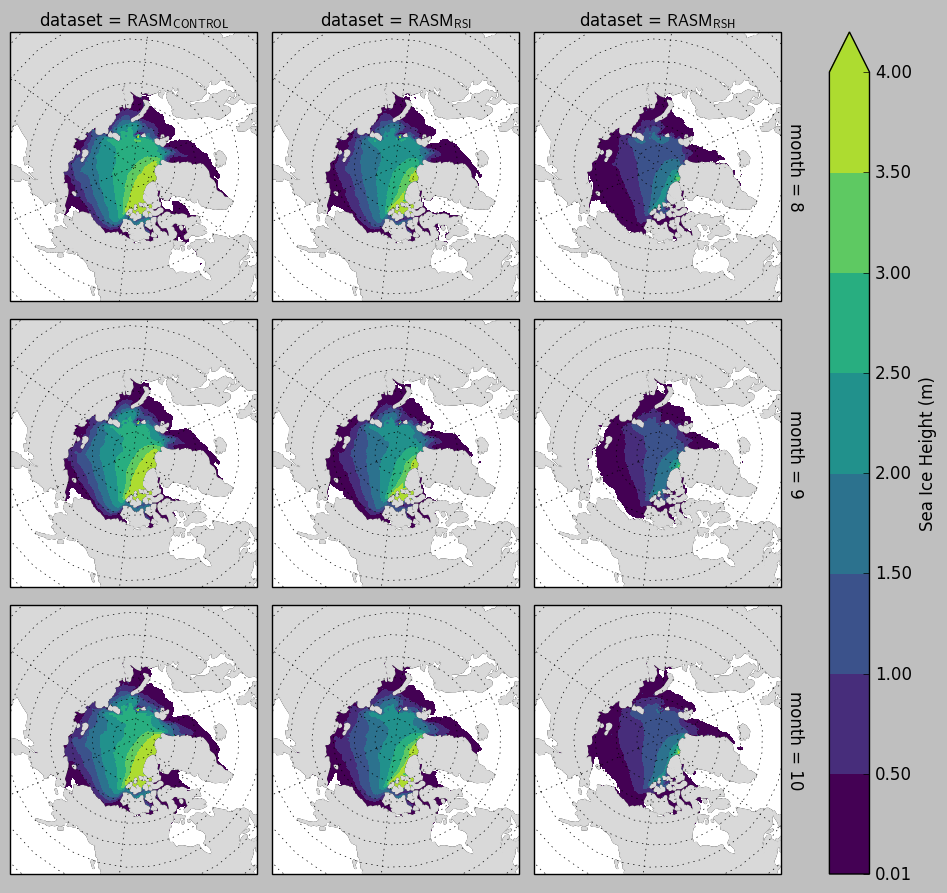

In [29]:
fg = da.where(da > 0).plot.pcolormesh('TLON', 'TLAT', col='dataset', row='month', 
                        transform=ccrs.PlateCarree(),
                        subplot_kws=dict(projection=ccrs.NorthPolarStereo(-114)),
                        cmap='viridis', extend='max', levels=[0.01, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
_ = [add_map_features(ax) for ax in fg.axes.flat]
fg.cbar.set_label('Sea Ice Height (m)')

fg.fig.savefig('../figs/seaice_height.png', dpi=300)